In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from numba import njit

In [2]:
# Refer to process_L2 in https://github.com/nkaz001/tardis-process/tardis-process.ipynb
#
# buy = sum(map(lambda x: x[1], filter(lambda x: x[0] > mid * (1 - p), bid.iteritems())))
# sell = sum(map(lambda x: x[1], filter(lambda x: x[0] < mid * (1 + p), ask.iteritems())))
# imbalance = buy - sell

In [5]:
df = pd.read_pickle('data')

In [6]:
@njit
def predict_njit(start_equity, A, B, half_spread, max_position, X, imbalance):
    tick_size = 0.5
    running_qty = 0
    static_equity = start_equity
    fee = 0
    equity = []
    running_qty_ = []
    order_qty = 100
    new_bid = np.nan
    new_ask = np.nan
    high = 1
    low = 2
    close = 3
    volume = 4
    best_bid = 5
    best_ask = 6
    #imbalance = 7
    for row in X:
        if new_bid > row[low] and row[volume] > 0:
            running_qty += order_qty
            static_equity += order_qty / new_bid
            fee += order_qty / new_bid * -0.00025    
        if new_ask < row[high] and row[volume] > 0:
            running_qty -= order_qty
            static_equity -= order_qty / new_ask
            fee += order_qty / new_ask * -0.00025    
        # equity.append(static_equity - running_qty / row[close] - fee)
        equity.append(static_equity * row[close] - running_qty - fee * row[close])
        running_qty_.append(running_qty)
        x = running_qty + equity[-1]
        skew = B * x / max_position * -1
        quote_mid_price = row[close] + A * row[imbalance] / 100000000 + skew
        new_bid = np.minimum(np.minimum(np.round(quote_mid_price * (1 - half_spread) / tick_size) * tick_size, row[close] - tick_size), row[best_bid])
        new_ask = np.maximum(np.maximum(np.round(quote_mid_price * (1 + half_spread) / tick_size) * tick_size, row[close] + tick_size), row[best_ask])
        if x > max_position:
            new_bid = np.nan
        if x < -max_position:
            new_ask = np.nan
    return equity, running_qty_

class Backtest:
    def __init__(self, equity=None, max_position=None, A=None, B=None, half_spread=None, imbalance=None):
        self.equity = equity
        self.max_position = max_position
        self.A = A
        self.B = B
        self.half_spread = half_spread
        self.imbalance = imbalance
        
    def set_params(self, A, B, half_spread, imbalance):
        self.A = A
        self.B = B
        self.half_spread = half_spread
        self.imbalance = imbalance
        return self
        
    def get_params(self, deep=True):
        return { 'equity': self.equity, 'max_position': self.max_position, 'A': self.A, 'B': self.B, 'half_spread': self.half_spread, 'imbalance': self.imbalance }
        
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        equity, running_qty = predict_njit(self.equity, self.A, self.B, self.half_spread, self.max_position, X, self.imbalance)
        return equity, running_qty
    
    def score(self, X):
        equity, _ = self.predict(X)
        returns = pd.Series(equity).pct_change().fillna(0)
#         bm_returns = pd.Series(X[:, 3]).pct_change().fillna(0)
#         returns_ = returns - bm_returns
        return np.divide(returns.mean(), returns.std())

In [7]:
train = df[(df.index >= '2019-7-1') & (df.index < '2020-1-1')]
valid = df[(df.index >= '2020-1-1') & (df.index < '2021-1-8')]

In [8]:
#parameters = { 'A': np.linspace(0.01, 1, 100), 'B': np.linspace(0.01, 1, 100), 'half_spread': np.linspace(0.001, 0.01, 10) }
#search = GridSearchCV(Backtest(10000, 10000), parameters)
#search.fit(df)

#param_dist = { 'A': stats.uniform(50, 500), 'B': stats.uniform(1, 50), 'half_spread': stats.uniform(0, 0.001), 'imbalance': np.arange(4, 13) }
param_dist = { 'A': stats.uniform(50, 500), 'B': stats.uniform(1, 50), 'half_spread': stats.uniform(0, 0.001), 'imbalance': np.arange(7, 16) }
search = RandomizedSearchCV(Backtest(1, 10000),
                            cv=[(np.arange(len(train)), np.arange(len(train)))],
                            param_distributions=param_dist,
                            verbose=1,
                            n_iter=1000,
                            n_jobs=8)
search.fit(train.values)

Fitting 1 folds for each of 1000 candidates, totalling 1000 fits


RandomizedSearchCV(cv=[(array([      0,       1,       2, ..., 3179517, 3179518, 3179519]),
                        array([      0,       1,       2, ..., 3179517, 3179518, 3179519]))],
                   estimator=<__main__.Backtest object at 0x7f509ecec950>,
                   n_iter=1000, n_jobs=8,
                   param_distributions={'A': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f509ecec990>,
                                        'B': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f509ececb50>,
                                        'half_spread': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f509ecece50>,
                                        'imbalance': array([ 7,  8,  9, 10, 11, 12, 13, 14, 15])},
                   verbose=1)

In [9]:
# v1.3 params
#search.best_params_ = { 'A': 53.69024193790823, 'B': 44.26080387202236, 'half_spread': 0.00091530679386619, 'imbalance': 7 }
#search.best_estimator_.set_params(**{ 'A': 53.69024193790823, 'B': 44.26080387202236, 'half_spread': 0.00091530679386619, 'imbalance': 7 })
search.best_params_ = { 'A': 53.69024193790823, 'B': 44.26080387202236, 'half_spread': 0.00091530679386619, 'imbalance': 10 }
search.best_estimator_.set_params(**{ 'A': 53.69024193790823, 'B': 44.26080387202236, 'half_spread': 0.00091530679386619, 'imbalance': 10 })

In [10]:
search.best_params_

{'A': 53.69024193790823,
 'B': 44.26080387202236,
 'half_spread': 0.00091530679386619,
 'imbalance': 10}

In [11]:
search.best_estimator_.score(train.values)

0.0020269683564859216

In [12]:
equity, running_qty = search.best_estimator_.predict(train.values)
equity = pd.Series(equity, index=train.index)
running_qty = pd.Series(running_qty, index=train.index)

<AxesSubplot:xlabel='timestamp'>

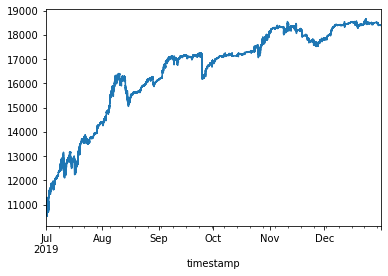

In [13]:
equity.plot()

<AxesSubplot:xlabel='timestamp'>

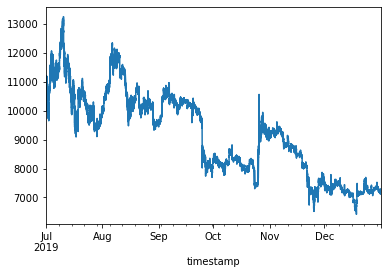

In [14]:
train["close"].plot()

<AxesSubplot:xlabel='timestamp'>

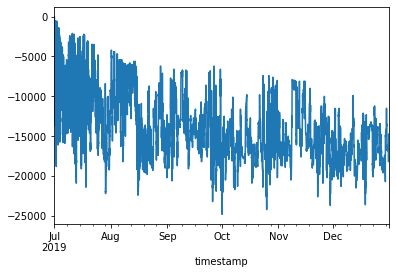

In [15]:
running_qty.plot()

Start date            2019-07-01
End date              2019-12-31
Time period (days)           183
Sharpe Ratio            3.870584
CAGR                     1.91761
Max Daily Drawdown      0.064947
dtype: object


<AxesSubplot:>

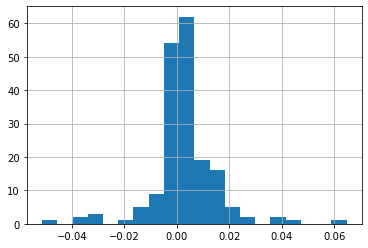

In [16]:
returns = equity.resample('1d').last().pct_change() 
bm_returns = train['close'].resample('1d').last().pct_change()
# returns_ = returns - bm_returns
returns_ = returns
sr = np.divide(returns_.mean(), returns_.std()) * np.sqrt(252)

equity_1d = equity.resample('1d').last()
Roll_Max = equity_1d.cummax()
Daily_Drawdown = np.divide(equity_1d, Roll_Max) - 1.0
Max_Daily_Drawdown = Daily_Drawdown.cummin()

period = (equity.index[-1] - equity.index[0]).days

print(pd.Series({
    'Start date': equity.index[0].strftime('%Y-%m-%d'),
    'End date': equity.index[-1].strftime('%Y-%m-%d'),
    'Time period (days)': period,
    'Sharpe Ratio': sr,
    'CAGR': (equity[-1] / equity[0]) ** (365 / period) - 1,
    'Max Daily Drawdown': -Max_Daily_Drawdown.min(),
}))

equity.resample('1d').last().pct_change().hist(bins=20)

In [17]:
equity, running_qty = search.best_estimator_.predict(valid.values)
equity = pd.Series(equity, index=valid.index)
running_qty = pd.Series(running_qty, index=valid.index)

<AxesSubplot:xlabel='timestamp'>

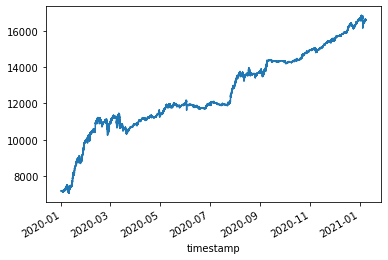

In [18]:
equity.plot()

<AxesSubplot:xlabel='timestamp'>

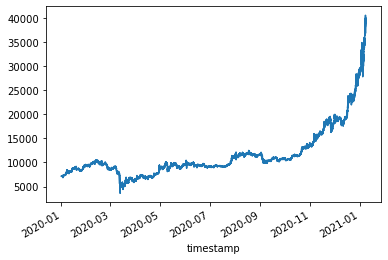

In [19]:
valid["close"].plot()

<AxesSubplot:xlabel='timestamp'>

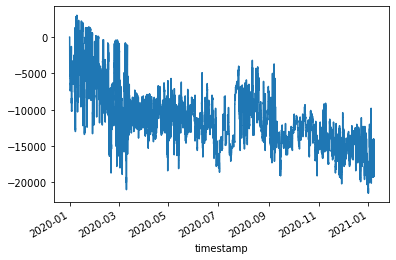

In [20]:
running_qty.plot()

Start date            2020-01-01
End date              2021-01-07
Time period (days)           372
Sharpe Ratio             3.65419
CAGR                    1.281043
Max Daily Drawdown      0.090666
dtype: object


<AxesSubplot:>

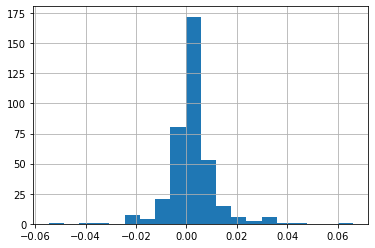

In [21]:
returns = equity.resample('1d').last().pct_change() 
bm_returns = valid['close'].resample('1d').last().pct_change()
#returns_ = returns - bm_returns
returns_ = returns
sr = np.divide(returns_.mean(), returns_.std()) * np.sqrt(252)

equity_1d = equity.resample('1d').last()
Roll_Max = equity_1d.cummax()
Daily_Drawdown = np.divide(equity_1d, Roll_Max) - 1.0
Max_Daily_Drawdown = Daily_Drawdown.cummin()

period = (equity.index[-1] - equity.index[0]).days

print(pd.Series({
    'Start date': equity.index[0].strftime('%Y-%m-%d'),
    'End date': equity.index[-1].strftime('%Y-%m-%d'),
    'Time period (days)': period,
    'Sharpe Ratio': sr,
    'CAGR': (equity[-1] / equity[0]) ** (365 / period) - 1,
    'Max Daily Drawdown': -Max_Daily_Drawdown.min(),
}))

equity.resample('1d').last().pct_change().hist(bins=20)

Start date                         2019-01-01
End date                           2021-05-03
Time period (days)                        852
Train period          2019-07-01 - 2019-12-31
Valid period          2020-01-01 - 2021-01-07
Sharpe ratio                         4.549735
CAGR                                 1.647033
RRR                                 31.418173
Maximum drawdown                     0.052423
dtype: object


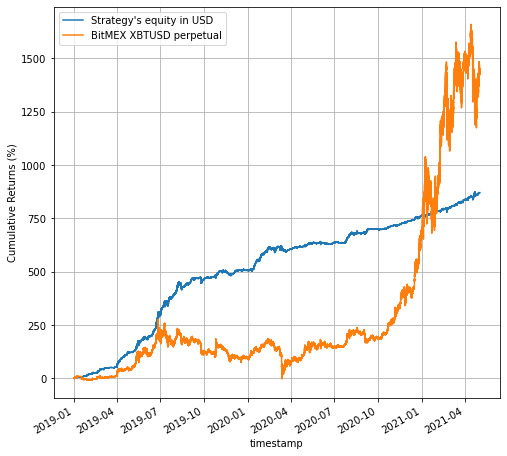

In [22]:
equity, running_qty = search.best_estimator_.predict(df.values)
equity = pd.Series(equity, index=df.index)
running_qty = pd.Series(running_qty, index=df.index)


returns = equity.resample('1d').last().pct_change() 
bm_returns = valid['close'].resample('1d').last().pct_change()
#returns_ = returns - bm_returns
returns_ = returns
sr = np.divide(returns_.mean(), returns_.std()) * np.sqrt(252)

equity_1d = equity.resample('1d').last()
Roll_Max = equity_1d.cummax()
Daily_Drawdown = np.divide(equity_1d, Roll_Max) - 1.0
Max_Daily_Drawdown = Daily_Drawdown.cummin()

period = (equity.index[-1] - equity.index[0]).days

print(pd.Series({
    'Start date': equity.index[0].strftime('%Y-%m-%d'),
    'End date': equity.index[-1].strftime('%Y-%m-%d'),
    'Time period (days)': period,
    'Train period': '%s - %s' % (train.index[0].strftime('%Y-%m-%d'), train.index[-1].strftime('%Y-%m-%d')),
    'Valid period': '%s - %s' % (valid.index[0].strftime('%Y-%m-%d'), valid.index[-1].strftime('%Y-%m-%d')),
    'Sharpe ratio': sr,
    'CAGR': (equity[-1] / equity[0]) ** (365 / period) - 1,
    'RRR': ((equity[-1] / equity[0]) ** (365 / period) - 1) / -Max_Daily_Drawdown.min(),
    'Maximum drawdown': -Max_Daily_Drawdown.min(),
}))

# equity.resample('1d').last().pct_change().hist(bins=20)

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
ax1 = ((equity / equity[0] - 1) * 100).plot()
ax2 = ((df['close'] / df['close'][0] - 1) * 100).plot()
ax1.set_ylabel('Cumulative Returns (%)')
ax1.legend(["Strategy's equity in USD", 'BitMEX XBTUSD perpetual'])
ax1.grid()

<AxesSubplot:xlabel='timestamp'>

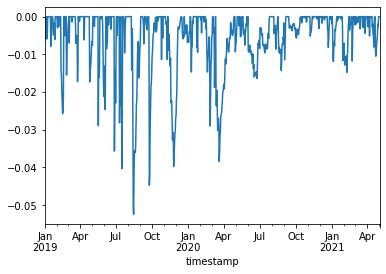

In [23]:
Daily_Drawdown.plot()

<AxesSubplot:xlabel='timestamp'>

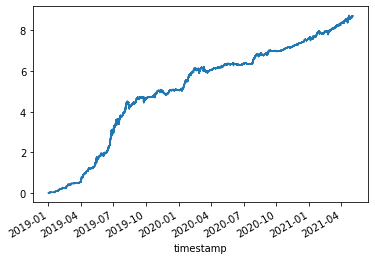

In [24]:
(equity / equity[0] - 1).plot()

<AxesSubplot:xlabel='timestamp'>

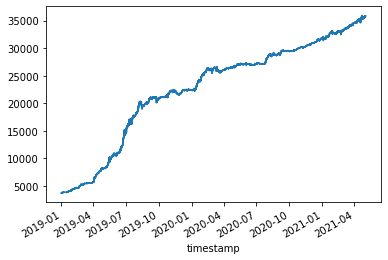

In [25]:
equity.fillna(0).plot()